In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

input_file = "/home/tim/cluster/openmp-usage-analysis/result.csv"
input_file_metadata = "/home/tim/scratch/openmp-usage-analysis-binaries/result.csv"

plot_path = "/home/tim/paper/openmp-analysis-paper/media"
df = pd.read_csv(input_file, index_col=0)

df_repo_metadata = pd.read_csv(input_file_metadata, index_col=0)

In [25]:
#pre-processing
df_repo_metadata["Code"] = df_repo_metadata["Code"].str.replace("/","--") 

In [2]:
OVERHEAD_THRESHOLD = 100

In [3]:
df["large_overhead"] = df["instructions_weighted"] < OVERHEAD_THRESHOLD
df["small_overhead"] = df["instructions_weighted"] >= OVERHEAD_THRESHOLD

In [4]:
len(df["Code"].unique())

233

In [5]:
pass

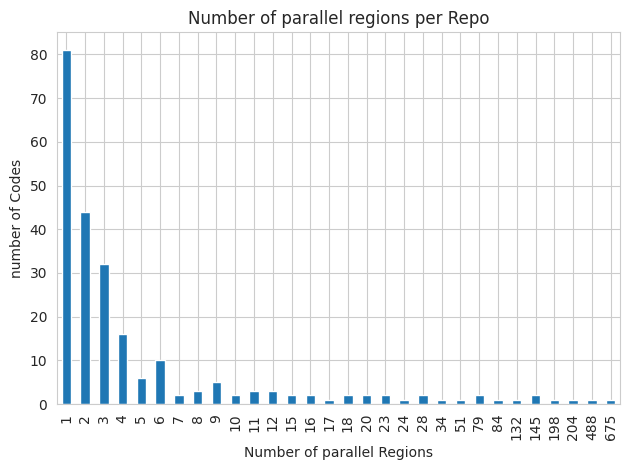

In [6]:
# Number of parallel regions per Repo
ax = df.groupby("Code").size().value_counts().sort_index().plot.bar()
ax.set_xlabel("Number of parallel Regions")
ax.set_ylabel("number of Codes")
ax.set_title("Number of parallel regions per Repo")
plt.savefig(os.path.join(plot_path, "num_regions.pdf"))
plt.tight_layout()
plt.show()


In [7]:
df["default_tripcount_loops"].sum()

102350

In [8]:
df["known_tripcount_loops"].sum()

975

In [9]:
df["thread_dependant_trip_count_loops"].sum()

822

Fragen:
Wie viele user beachten die aspekte um gute openmp usage zu haben


Analyse per project

Verhältnis overhead/parallel region per project
overhead mit 100 instructions annehmen
codegröße insgesamt
Wie viele regions per project, welcher typ

welche konstrukte

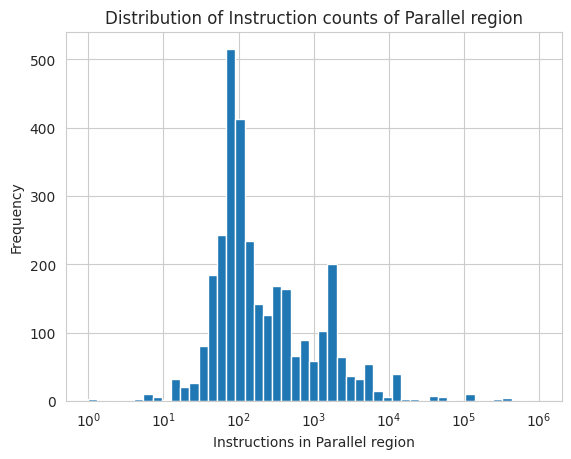

In [10]:
ax = df["instructions_flat"].plot.hist(bins=np.logspace(start=0, stop=6))
ax.set_xscale("log")
ax.set_xlabel("Instructions in Parallel region")
ax.set_title("Distribution of Instruction counts of Parallel region")
plt.savefig(os.path.join(plot_path, "flat_instructions_distribution.pdf"))

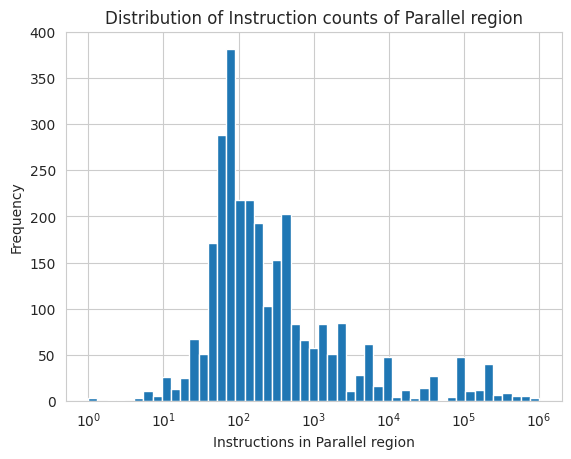

In [11]:
# mit anderem default tripcount 10k oder so
ax = df["instructions_weighted"].plot.hist(bins=np.logspace(start=0, stop=6, num=50))
ax.set_xscale("log")
ax.set_xlabel("Instructions in Parallel region")
ax.set_title("Distribution of Instruction counts of Parallel region")
plt.savefig(os.path.join(plot_path, "weighted_instructions_distribution.pdf"))

In [12]:
df_overhead_rating = df.groupby("Code")[["large_overhead", "small_overhead"]].sum()
df_overhead_rating['percentage'] = df_overhead_rating['large_overhead'] / (
        df_overhead_rating['large_overhead'] + df_overhead_rating['small_overhead'])

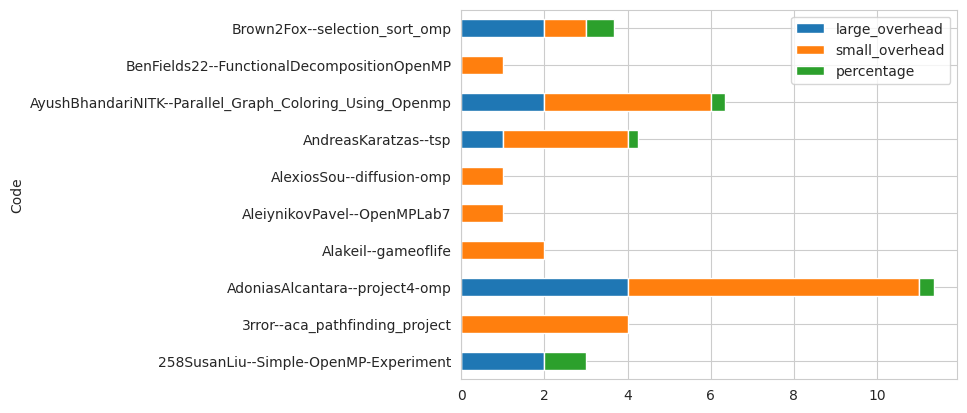

In [13]:
# plot an excerpt
ax = df_overhead_rating.iloc[0:10].plot.barh(stacked=True)

In [14]:
# Repos with at least one example of large overhead region
(df_overhead_rating["large_overhead"] > 1).sum()

66

Text(0.5, 1.0, 'Fraction of high overhead parallel regions per project')

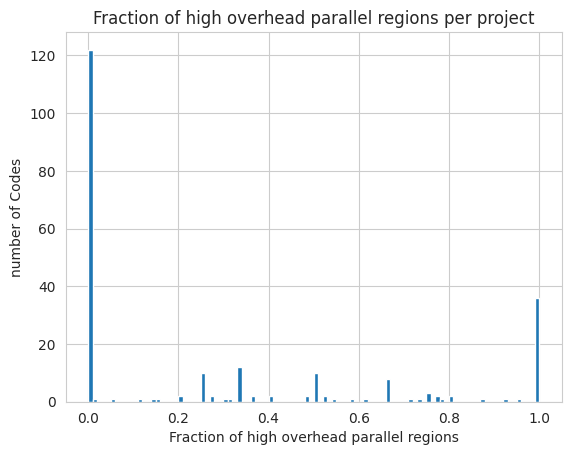

In [15]:
ax = df_overhead_rating['percentage'].plot.hist(bins=100)
ax.set_xlabel("Fraction of high overhead parallel regions")
ax.set_ylabel("number of Codes")
ax.set_title("Fraction of high overhead parallel regions per project")

#plt.savefig(os.path.join(plot_path,"plot.pdf"))

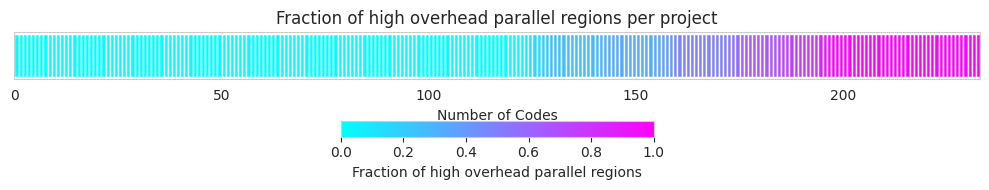

In [16]:
fig, ax = plt.subplots(figsize=(10, 2))

data = df_overhead_rating['percentage'].sort_values()

# Normalize the percentage values to use as colors
# Normalize the percentage values to use as colors
norm = plt.Normalize(data.min(), data.max())
sm = plt.cm.ScalarMappable(cmap="cool", norm=norm)
colors = sm.to_rgba(data)

# Plot the horizontal bar segments
start = 0
for i, percentage in enumerate(data):
    ax.barh(0, 1, left=start, color=colors[i]
            #, edgecolor='black'
            )
    start += 1

# Set the labels and title
ax.set_xlabel("Number of Codes")
ax.set_yticks([])  # Hide y-axis ticks
ax.set_xlim([0, len(data)])
ax.set_title("Fraction of high overhead parallel regions per project")

# Add a legend
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.4)
cbar.set_label('Fraction of high overhead parallel regions')
fig.tight_layout()
plt.savefig(os.path.join(plot_path, "fraction_per_project.pdf"))
plt.show()


In [17]:
#df_loops = df.groupby("Code")[["default_tripcount_loops","known_tripcount_loops","thread_dependant_trip_count_loops"]].sum()

In [18]:
df["loop_sum"] = df[["default_tripcount_loops", "known_tripcount_loops", "thread_dependant_trip_count_loops"]].sum(
    axis=1)

In [19]:
df

,name,addr,instructions_flat,instructions_weighted,default_tripcount_loops,known_tripcount_loops,thread_dependant_trip_count_loops,recursions,TOTAL_FILE_INSTR_COUNT,DEFAULT_TRIPCOUNT_GUESS,Code,File,large_overhead,small_overhead,loop_sum
0,main._omp_fn.0,4198000,252,80757.054688,7,0,1,0,512,3,PerJNilsson--C---OpenMP,cell_distance,False,True,8
0,main._omp_fn.0,4235346,344,448.000000,5,0,1,0,6947,3,DmitryGusev91--Parallel-computation-MPI-OpenMP,program,False,True,6
0,_Z11P_MergeSortIiEvPT_S1_i._omp_fn.0,4201840,55,34.000000,0,0,0,0,1945,3,aydinbuluc--cs267-openmp-mergesort,a.out,True,False,0
1,_Z7P_MergeIiEvPT_S1_S1_ii._omp_fn.0,4202048,72,46.500000,0,0,0,0,1945,3,aydinbuluc--cs267-openmp-mergesort,a.out,True,False,0
2,_Z7P_MergeIiEvPT_S1_S1_ii._omp_fn.2,4203488,18,18.000000,5,0,0,0,1945,3,aydinbuluc--cs267-openmp-mergesort,a.out,True,False,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,rindow_matlib_s_zeros._omp_fn.1,4324280,60,58.250000,0,0,1,0,33316,3,rindow--rindow-matlib,librindowmatlib.so,True,False,1
200,rindow_matlib_d_zeros._omp_fn.0,4324444,69,58.500000,0,0,1,0,33316,3,rindow--rindow-matlib,librindowmatlib.so,True,False,1
201,rindow_matlib_d_zeros._omp_fn.1,4324636,60,52.000000,0,0,1,0,33316,3,rindow--rindow-matlib,librindowmatlib.so,True,False,1
202,rindow_matlib_i_zeros._omp_fn.0,4324800,69,66.000000,0,0,1,0,33316,3,rindow--rindow-matlib,librindowmatlib.so,True,False,1


Text(0.5, 1.0, 'Distribution of loop counts in Parallel region')

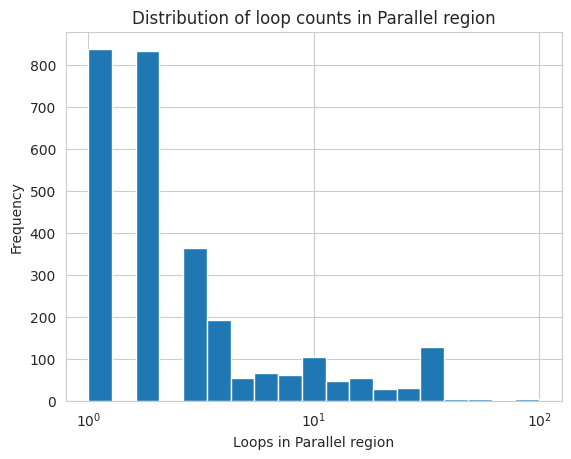

In [20]:
ax = df["loop_sum"].plot.hist(bins=np.logspace(start=0, stop=2, num=20))
ax.set_xscale("log")
ax.set_xlabel("Loops in Parallel region")
ax.set_title("Distribution of loop counts in Parallel region")
#plt.savefig(os.path.join(plot_path, "loops_distribution.pdf"))

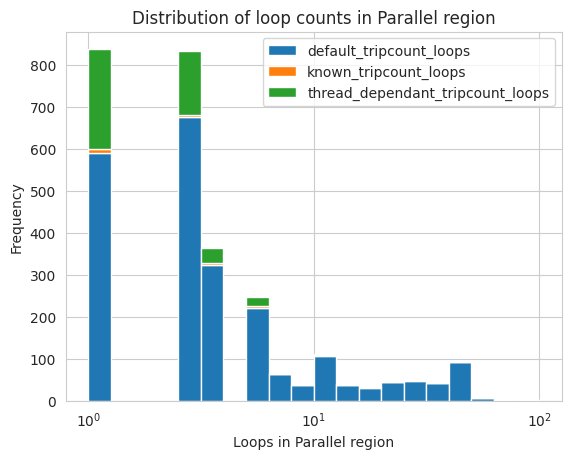

In [21]:
# manual sorting into the bins
bins = np.logspace(start=0, stop=2, num=21)

default = [0 for _ in range(len(bins) + 1)]
known = [0 for _ in range(len(bins) + 1)]
thread = [0 for _ in range(len(bins) + 1)]

for idx, row in df.iterrows():
    if row['loop_sum'] > 0:
        b_index = np.searchsorted(bins, row["loop_sum"])
        default[b_index] += row["default_tripcount_loops"] / row["loop_sum"]
        known[b_index] += row["known_tripcount_loops"] / row["loop_sum"]
        thread[b_index] += row["thread_dependant_trip_count_loops"] / row["loop_sum"]

default = default[:-2]
known = known[:-2]
thread = thread[:-2]

fig, ax = plt.subplots()
ax.bar(
    bins[:-1],
    default,
    label="default_tripcount_loops",
    width=np.diff(bins),
    align='edge',
)
ax.bar(
    bins[:-1],
    known,
    bottom=default,
    label="known_tripcount_loops",
    width=np.diff(bins),
    align='edge',
)
ax.bar(
    bins[:-1],
    thread,
    bottom=np.add(default, known),
    label="thread_dependant_tripcount_loops",
    width=np.diff(bins),
    align='edge',
)

ax.set_xscale("log")
ax.set_xlabel("Loops in Parallel region")
ax.set_ylabel("Frequency")
# bar coloring according to percentages of loops
ax.set_title("Distribution of loop counts in Parallel region")
ax.legend()

plt.savefig(os.path.join(plot_path, "loops_distribution.pdf"))
plt.show()

In [22]:
# per file statistics
df_parallel_portion = df.groupby(["Code", "File"]).agg(
    instructions_flat=pd.NamedAgg(column="instructions_flat", aggfunc="sum"),
    TOTAL_FILE_INSTR_COUNT=pd.NamedAgg(column="TOTAL_FILE_INSTR_COUNT", aggfunc="max")
).reset_index()
# per project
df_parallel_portion = df_parallel_portion.groupby("Code")[["instructions_flat", "TOTAL_FILE_INSTR_COUNT"]].sum()
df_parallel_portion["percent_parallel"] = df_parallel_portion["instructions_flat"] / (
            df_parallel_portion["instructions_flat"] + df_parallel_portion["TOTAL_FILE_INSTR_COUNT"])
df_parallel_portion

,instructions_flat,TOTAL_FILE_INSTR_COUNT,percent_parallel
Code,,,
258SusanLiu--Simple-OpenMP-Experiment,98,372,0.208511
3rror--aca_pathfinding_project,14754,10894,0.575250
AdoniasAlcantara--project4-omp,935,1511,0.382257
Alakeil--gameoflife,484,826,0.369466
AleiynikovPavel--OpenMPLab7,148,472,0.238710
...,...,...,...
zetechmoy--bruteforce-openmp,104,340,0.234234
zhishang72--MatrixMulMatrix,306,664,0.315464
zjzoloo--mandelbrot-with-openMP,119,19914,0.005940


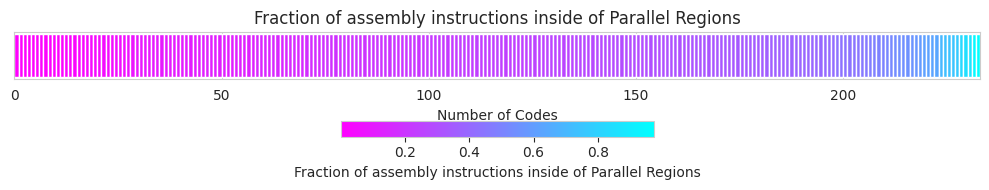

In [23]:
fig, ax = plt.subplots(figsize=(10, 2))

data = df_parallel_portion['percent_parallel'].sort_values()

# Normalize the percentage values to use as colors
# Normalize the percentage values to use as colors
norm = plt.Normalize(data.min(), data.max())
sm = plt.cm.ScalarMappable(cmap=plt.colormaps.get_cmap("cool").reversed(), norm=norm)
colors = sm.to_rgba(data)

# Plot the horizontal bar segments
start = 0
for i, percentage in enumerate(data):
    ax.barh(0, 1, left=start, color=colors[i]
            #, edgecolor='black'
            )
    start += 1

# Set the labels and title
ax.set_xlabel("Number of Codes")
ax.set_yticks([])  # Hide y-axis ticks
ax.set_xlim([0, len(data)])
ax.set_title("Fraction of assembly instructions inside of Parallel Regions")

# Add a legend
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.4)
cbar.set_label('Fraction of assembly instructions inside of Parallel Regions')
fig.tight_layout()
plt.savefig(os.path.join(plot_path, "fraction_per_project.pdf"))
plt.show()

In [33]:
#pd.to_datetime(df_repo_metadata["PushDate"])


'-10018015'